In [1]:
#import all the required libraries
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import Image, HTML
from plotnine import *
import pydot
from plotnine import *
from tqdm import tqdm
from scipy.optimize import curve_fit
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import pairwise_distances
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from six import StringIO
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split as split

In [2]:
# Setting the file path for the CSV file containing the Spotify dataset
path = '/content/spotify_dataset-2.csv'

# Reading the CSV file using pandas and storing the data in a DataFrame named 'df'
df = pd.read_csv(path)

# Displaying the first few rows of the DataFrame to get an overview of the data
df.head()


,track_name,artists,avg_artist_popularity,avg_artist_followers,popularity,danceability,duration_ms,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,time_signature,valence,genres,country
0,Water,Tyla,75.0,350796.0,95,0.673,200256,0.722,3,-3.495,0,0.0755,0.0856,0.000000,0.1370,4,0.519,[],US
1,Lovin On Me,Jack Harlow,83.0,3207807.0,96,0.943,138411,0.558,2,-4.911,1,0.0568,0.0026,0.000002,0.0937,4,0.606,deep underground hip hop,US
2,greedy,Tate McRae,83.0,4226857.0,100,0.750,131872,0.733,6,-3.180,0,0.0319,0.2560,0.000000,0.1140,1,0.844,alt z,US
3,Houdini,Dua Lipa,85.0,42470282.0,93,0.744,185918,0.789,9,-4.876,0,0.0590,0.0036,0.001440,0.0947,4,0.866,dance pop,US
4,MY HOUSE,Beyoncé,83.0,36625984.0,80,0.494,262941,0.849,0,-6.438,0,0.3430,0.0748,0.001520,0.7910,5,0.512,pop,US


In [3]:
# Displaying a summary of the DataFrame 'df'.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3891 entries, 0 to 3890
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   track_name             3891 non-null   object 
 1   artists                3891 non-null   object 
 2   avg_artist_popularity  3891 non-null   float64
 3   avg_artist_followers   3891 non-null   float64
 4   popularity             3891 non-null   int64  
 5   danceability           3891 non-null   float64
 6   duration_ms            3891 non-null   int64  
 7   energy                 3891 non-null   float64
 8   key                    3891 non-null   int64  
 9   loudness               3891 non-null   float64
 10  mode                   3891 non-null   int64  
 11  speechiness            3891 non-null   float64
 12  acousticness           3891 non-null   float64
 13  instrumentalness       3891 non-null   float64
 14  liveness               3891 non-null   float64
 15  time

In [4]:
# Creating a list of column names that are of interest in the DataFrame
columns = ['track_name', 'artists', 'genres', 'country']

# Iterating through each column name in the list
for col in columns:
    # Printing the column name and the number of unique values it contains
    # The formatting in the string ensures that the column names are left-aligned
    print(f'{col:<15}: {df[col].nunique()} unique values')


track_name     : 3527 unique values
artists        : 3014 unique values
genres         : 326 unique values
country        : 8 unique values


In [5]:
# Dropping the 'genres' and 'track_name' columns from the DataFrame 'df'.
# The 'axis=1' parameter indicates that columns (not rows) are being dropped.
df = df.drop(labels=['genres', 'track_name'], axis=1)

# Displaying the shape of the DataFrame after the columns have been dropped.
# This will show the number of rows and columns remaining in 'df'.
df.shape


(3891, 17)

In [6]:
# Checking for duplicated rows in the DataFrame 'df'.
# The 'duplicated()' method returns a boolean Series indicating whether each row is a duplicate or not.
# The 'sum()' function is then used to count the total number of duplicated rows.
df.duplicated().sum()


178

In [7]:
# Removing duplicate rows from 'df' and displaying its new dimensions.
df = df[~df.duplicated() == 1]
df.shape


(3713, 17)

In [8]:
# Calculating the total number of missing values in the entire DataFrame.
df.isnull().sum().sum()


0

In [9]:
# Separating numeric and string columns in 'df' and printing their counts.
numeric_columns = df.columns[df.dtypes != 'object']
string_columns = df.columns[df.dtypes == 'object']
print(f'There are {len(numeric_columns)} numeric columns & {len(string_columns)} string columns')

There are 15 numeric columns & 2 string columns


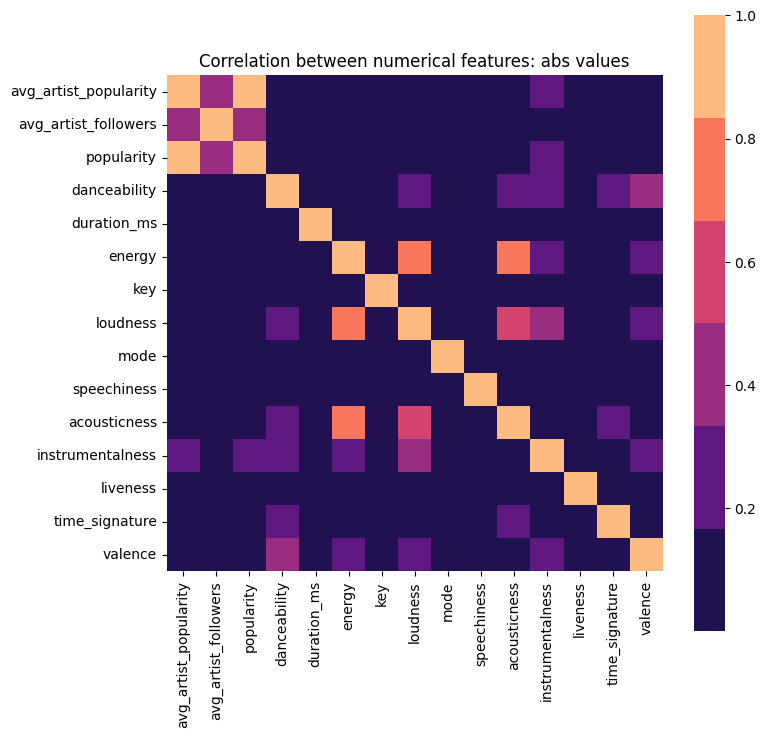

In [10]:
# Creating a heatmap to visualize correlations between numeric features in 'df'.
# Absolute values of correlations are used for clearer interpretation.
numeric_df = pd.DataFrame(data=df, columns=numeric_columns, index=df.index)
corr = np.abs(numeric_df.corr())  # Calculating absolute correlations
fig, ax = plt.subplots(figsize=(8, 8))  # Setting up the plot
cmap = sns.color_palette("magma")  # Choosing the color palette
sns.heatmap(corr, cmap=cmap, square=True)  # Creating the heatmap
plt.title('Correlation between numerical features: abs values')  # Adding a title
plt.show()  # Displaying the heatmap

In [11]:
# Identifying and printing features most linearly correlated to 'popularity'.
series = np.abs(corr['popularity']).sort_values(ascending=False)  # Sorting correlations to 'popularity'
print('The most linear correlated features to POPULARITY are:')
for i, row in enumerate(series):
    if 0.2 <= row < 1:  # Filtering for strong correlations (excluding self-correlation)
        print(f'{series.index[i]:17} --> {row: .2f} (abs)')  # Printing feature name and correlation value


The most linear correlated features to POPULARITY are:
avg_artist_popularity -->  0.92 (abs)
avg_artist_followers -->  0.46 (abs)


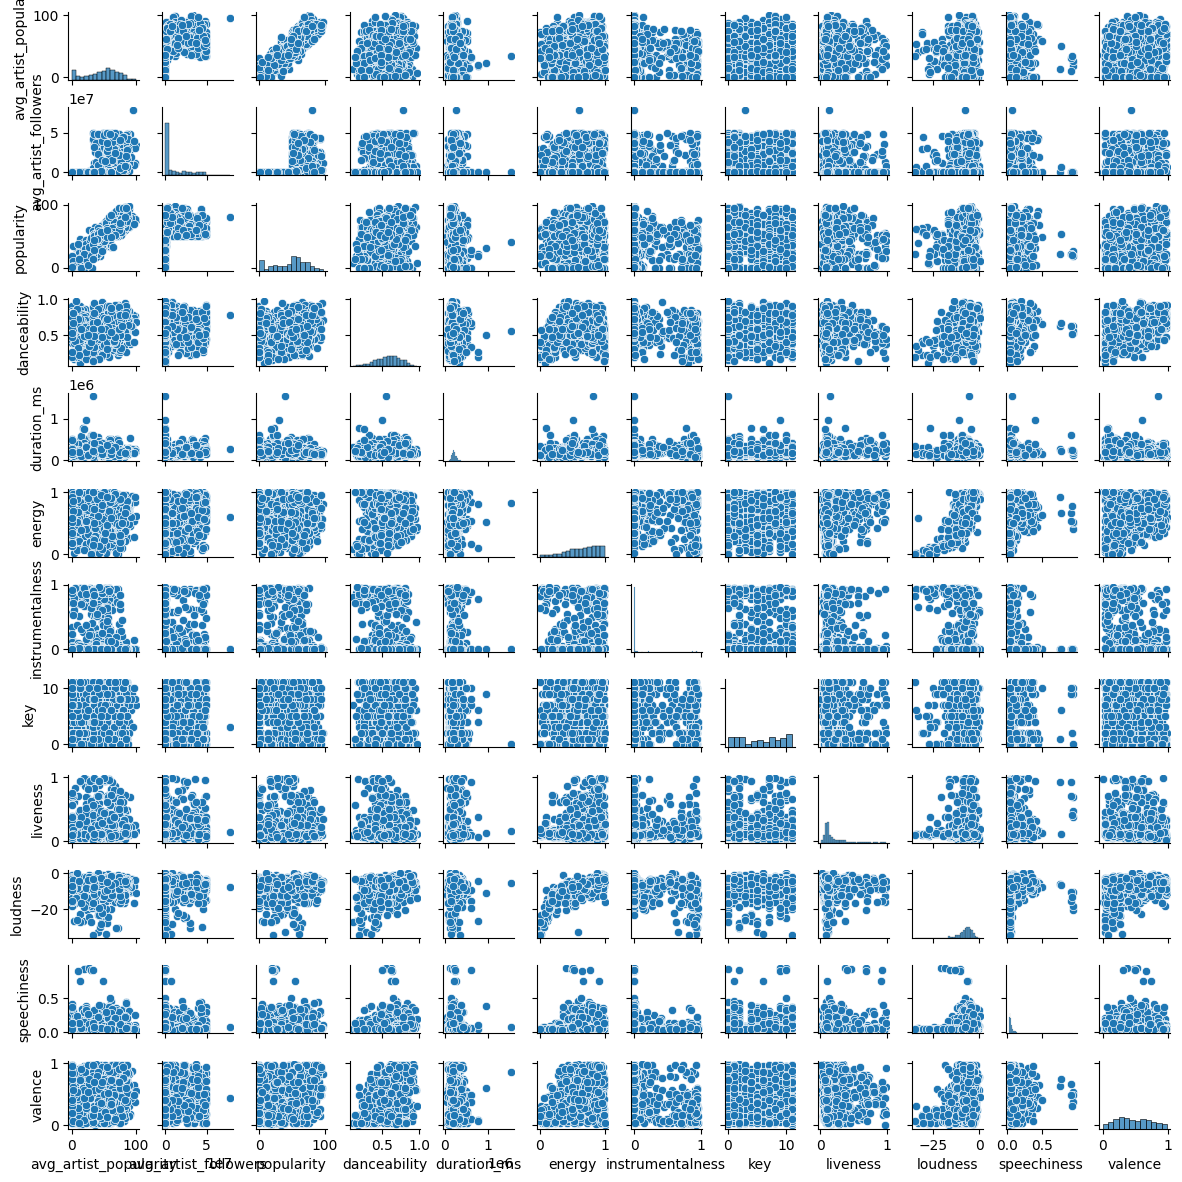

In [12]:
# 'Pairplot of Numerical Features exc. dummies'
# Data is sampled here due to long running time
sns_plot = sns.pairplot(df.sample(1000), height=1, vars=['avg_artist_popularity', 'avg_artist_followers', 'popularity','danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness',
       'speechiness', 'valence'])
        # sns_plot.savefig('pairplot.png')
plt.show()

In [13]:
# Counting the number of unique artists in the 'artists' column of 'df'.
df['artists'].nunique()

3014

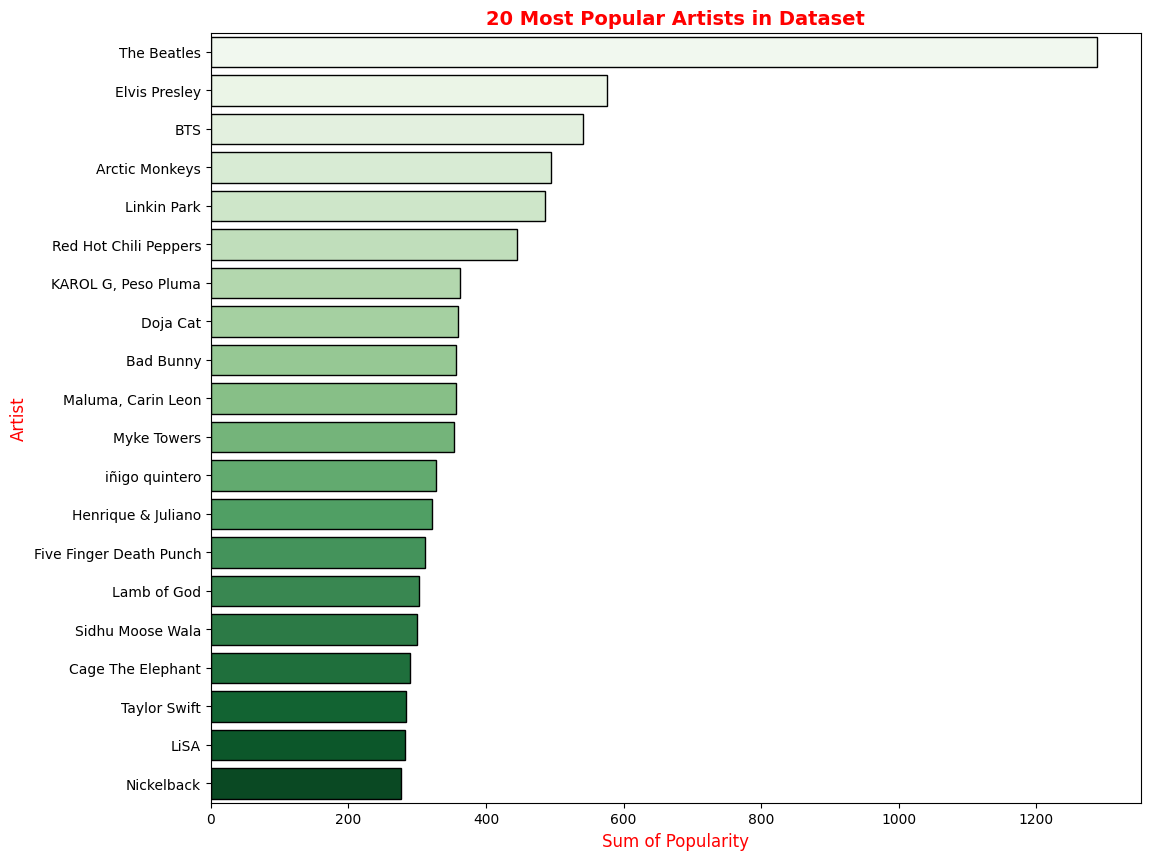

In [14]:
# Plotting the 20 most popular artists based on the sum of their song popularity.
fig, ax = plt.subplots(figsize = (12, 10))  # Setting the figure size
# Grouping by 'artists', summing 'popularity', sorting, and selecting top 20
lead_artists = df.groupby('artists')['popularity'].sum().sort_values(ascending=False).head(20)
# Creating a horizontal bar plot with custom aesthetics
ax = sns.barplot(x=lead_artists.values, y=lead_artists.index, palette="Greens", orient="h", edgecolor='black', ax=ax)
ax.set_xlabel('Sum of Popularity', c='r', fontsize=12)  # Setting X-axis label
ax.set_ylabel('Artist', c='r', fontsize=12)  # Setting Y-axis label
# Setting title with custom font size and weight
ax.set_title('20 Most Popular Artists in Dataset', c='r', fontsize=14, weight = 'bold')
plt.show()  # Displaying the plot


<ipython-input-15-1c6673358a2c>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



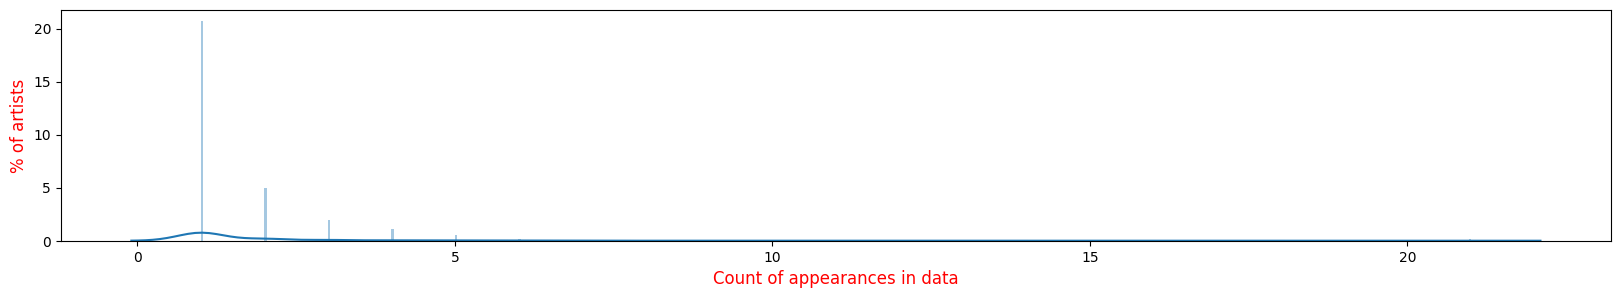

In [15]:
# Adding mean and count of song popularity for each artist in 'df'.
df['mean'] = df.groupby('artists')['popularity'].transform('mean')  # Calculating mean popularity
df['count'] = df.groupby('artists')['popularity'].transform('count')  # Counting number of songs

# Plotting the distribution of the count of song appearances by artists.
fig, ax = plt.subplots(figsize = (20, 3))  # Setting plot size
ax = sns.distplot(df['count'], bins = 600)  # Creating a distribution plot with a specified number of bins
ax.set_xlabel('Count of appearances in data', fontsize=12, c='r')  # Setting X-axis label
ax.set_ylabel('% of artists', fontsize=12, c='r')  # Setting Y-axis label
plt.show()  # Displaying the plot


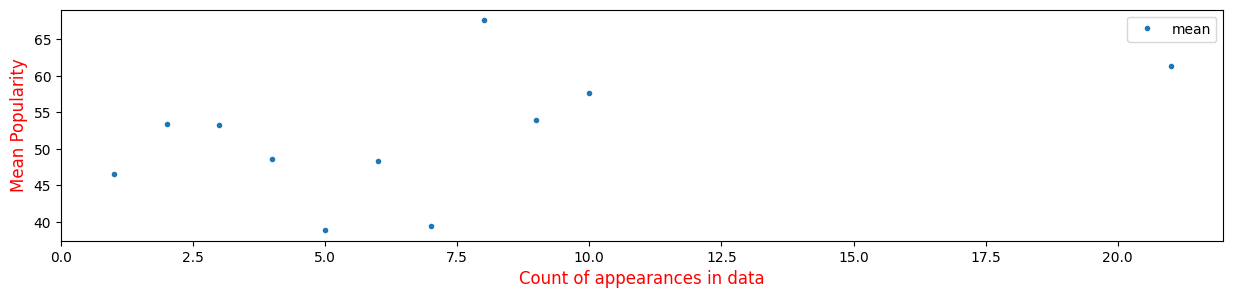

In [16]:
# Plotting the relationship between the number of song appearances and mean popularity for artists.
fig, ax = plt.subplots(figsize = (15, 3))  # Setting plot size
# Grouping by 'count', calculating the mean of 'mean' popularity, and resetting index for plotting
stat = df.groupby('count')['mean'].mean().to_frame().reset_index()
# Plotting with markers, no line, using the grouped data
ax = stat.plot(x='count', y='mean', marker='.', linestyle = '', ax=ax)
ax.set_xlabel('Count of appearances in data', fontsize=12, c='r')  # Setting X-axis label
ax.set_ylabel('Mean Popularity', fontsize=12, c='r')  # Setting Y-axis label
plt.show()  # Displaying the plot

<ipython-input-17-32567b4108e6>:10: MatplotlibDeprecationWarning: Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.


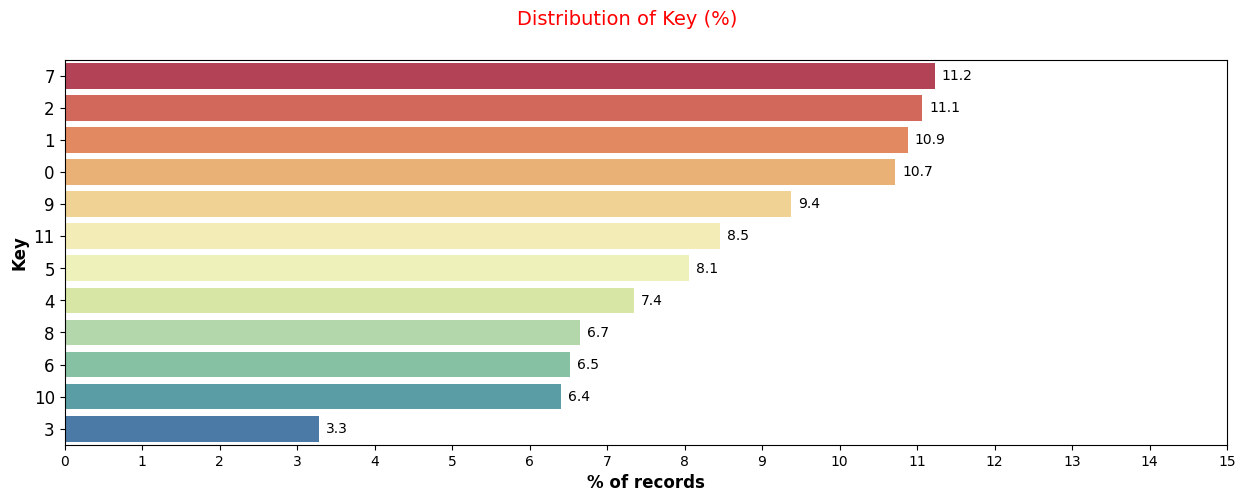

In [17]:
# Plotting the distribution of musical key in the dataset as a percentage.
fig, ax = plt.subplots(figsize = (15, 5))  # Setting plot size
# Calculating the normalized value counts of the 'key' column
key_data = df['key'].value_counts(normalize=True, sort=True, ascending=True) * 100
y_ticks = df['key'].value_counts().index
# Creating a horizontal bar plot
ax = sns.barplot(x=key_data.values, y=y_ticks, data=key_data, orient='h', palette='Spectral')
ax.set_xlabel('% of records', fontsize=12, weight='bold')  # Setting X-axis label
ax.set_ylabel('Key', fontsize=12, weight='bold')  # Setting Y-axis label
ax.set_xlim(0.0, 15.0, 0)  # Setting X-axis limits
ax.set_xticks(ticks=range(0, 16, 1))  # Setting X-axis ticks
ax.set_yticklabels(labels=y_ticks, fontsize=12)  # Setting Y-axis labels

# Adding data labels to each bar
rects = ax.patches
for rect in rects:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    space = 5  # Space between bar and label
    ha = 'left'  # Horizontal alignment
    label = f'{x_value:.1f}'  # Formatting label
    plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords="offset points", va='center', ha=ha)

plt.suptitle('Distribution of Key (%)', fontsize=14, c='r')  # Setting plot title
plt.show()  # Displaying the plot


<ipython-input-18-71fa11e5186b>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.



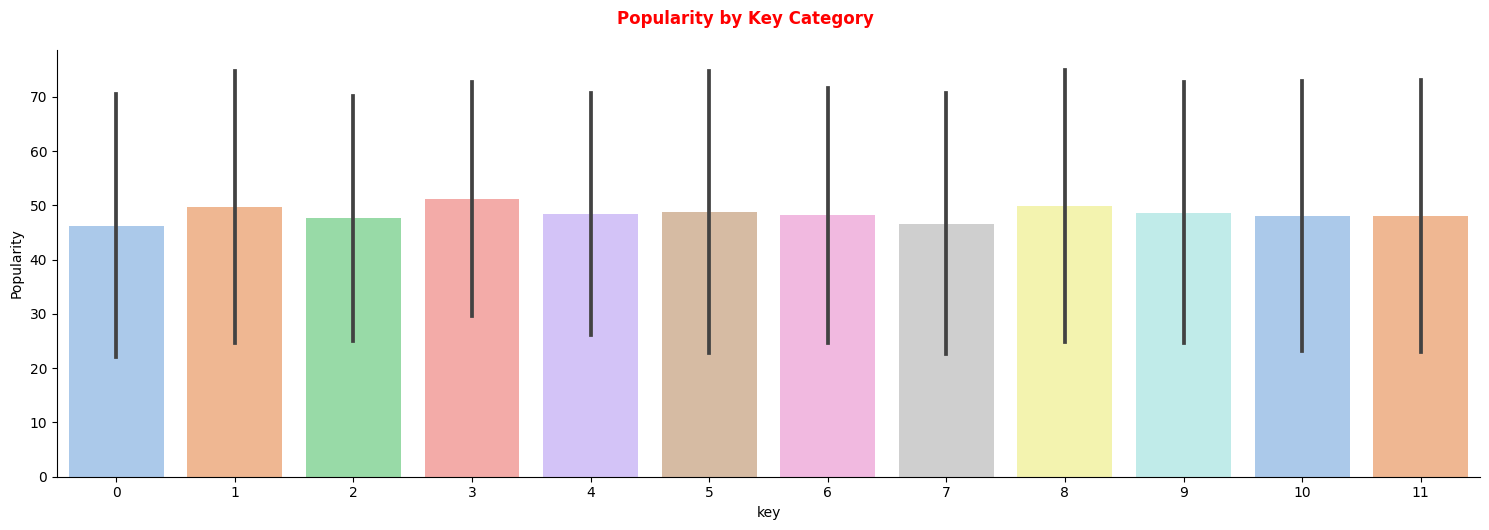

In [18]:
# Creating a categorical bar plot to show the average popularity by musical key in 'df'.
exp_data = sns.catplot(data=df, kind="bar",
                       x="key", y="popularity",
                       palette='pastel',
                       ci='sd',  # Showing standard deviation as error bars
                       height=5, aspect=3)  # Setting the size and aspect ratio of the plot
# Setting the title of the plot with custom formatting
exp_data.fig.suptitle('Popularity by Key Category', y=1.05, c='r', weight='bold')
exp_data.set_axis_labels("key", "Popularity")  # Setting X and Y axis labels
plt.show()  # Displaying the plot

In [19]:
# Describe - all
df['popularity'].describe()

count    3713.000000
mean       48.182332
std        24.141831
min         0.000000
25%        32.000000
50%        53.000000
75%        65.000000
max       100.000000
Name: popularity, dtype: float64

In [20]:
# Describe - Popularity > 0
df.loc[df['popularity']>0,'popularity'].describe()

count    3456.000000
mean       51.765336
std        20.991727
min         1.000000
25%        39.000000
50%        54.000000
75%        66.000000
max       100.000000
Name: popularity, dtype: float64

<ipython-input-21-6fc144b47f68>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

<ipython-input-21-6fc144b47f68>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



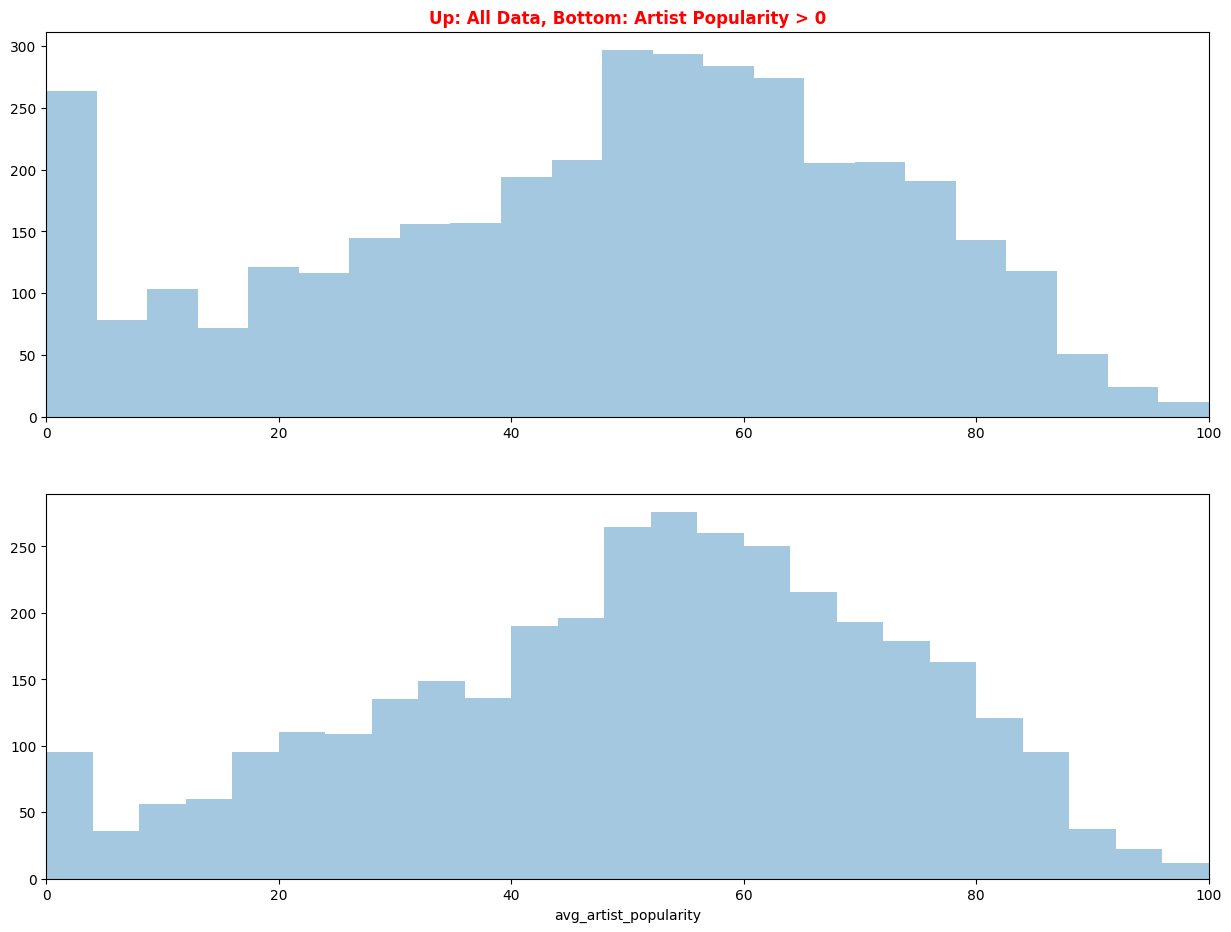

In [21]:
# Creating two subplots to compare distributions of average artist popularity.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 11))  # Setting up a 2-row subplot
# Plotting histogram for all data on the first subplot
ax1 = sns.distplot(df['avg_artist_popularity'], kde=False, ax=ax1)
# Plotting histogram for data where artist popularity is greater than 0 on the second subplot
ax2 = sns.distplot(df.loc[df['popularity'] > 0, 'avg_artist_popularity'], ax=ax2, kde=False)
ax1.set_xlim(0, 100)  # Setting X-axis limit for the first plot
ax2.set_xlim(0, 100)  # Setting X-axis limit for the second plot
ax1.set_xlabel('')  # Clearing X-axis label for the first plot
# Setting a title for the plots
ax1.set_title('Up: All Data, Bottom: Artist Popularity > 0', c='r', weight='bold')
plt.show()  # Displaying the plots

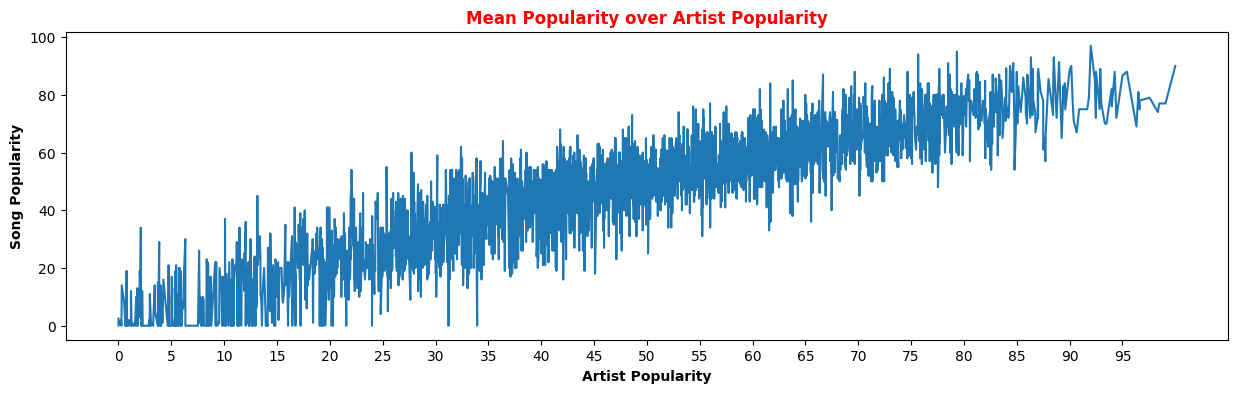

In [22]:
# Plotting the mean song popularity against average artist popularity.
fig, ax = plt.subplots(figsize=(15, 4))  # Setting the size of the plot
# Grouping by average artist popularity and plotting the mean song popularity
ax = df.groupby('avg_artist_popularity')['popularity'].mean().plot()
ax.set_title('Mean Popularity over Artist Popularity', c='r', weight='bold')  # Setting the plot title
ax.set_ylabel('Song Popularity', weight='bold')  # Setting Y-axis label
ax.set_xlabel('Artist Popularity', weight='bold')  # Setting X-axis label
ax.set_xticks(range(0, 100, 5))  # Setting X-axis ticks
plt.show()  # Displaying the plot

Pre processing

In [23]:
# Read column names from file
cols = list(pd.read_csv(path, nrows =1))
df = pd.read_csv(path, usecols=[i for i in cols if i not in ['track_name','genres']])

# Remove duplicated
df = df[~df.duplicated()==1]

#Split the data to train and test
X_train, X_test, y_train, y_test = split(df.drop('popularity', axis=1), df['popularity'], test_size = 0.2, random_state = 12345)

In [24]:
# Defining a custom transformer class 'ArtistsTransformer' for processing artist data.
class ArtistsTransformer():
    def __init__(self, MinCnt=3.0, MaxCnt=600.0):
        # Initializing with minimum and maximum artist appearance thresholds.
        self.MinCnt = MinCnt
        self.MaxCnt = MaxCnt
        self.artists_df = None

    def fit(self, X, y):
        # Creating a DataFrame to store mean and count statistics of artists.
        self.artists_df = y.groupby(X.artists).agg(['mean', 'count'])
        # Handling unknown artists by setting their values to overall mean and count of 1.
        self.artists_df.loc['unknown'] = [y.mean(), 1]
        # Setting mean popularity to overall mean for artists below MinCnt.
        self.artists_df.loc[self.artists_df['count'] <= self.MinCnt, 'mean'] = y.mean()
        # Setting mean popularity to 0 for artists above MaxCnt.
        self.artists_df.loc[self.artists_df['count'] >= self.MaxCnt, 'mean'] = 0
        return self

    def transform(self, X, y=None):
        # Replacing artist names with their mean popularity score or 'unknown'.
        X['artists'] = np.where(X['artists'].isin(self.artists_df.index), X['artists'], 'unknown')
        X['artists'] = X['artists'].map(self.artists_df['mean'])
        return X

In [25]:
# Applying the ArtistsTransformer to the train and test datasets separately.
artists_transformer = ArtistsTransformer(MinCnt=2)  # Creating an instance of the transformer with a specific MinCnt
# Fitting the transformer to the training data and transforming X_train
X_train = artists_transformer.fit(X_train, y_train).transform(X_train, y_train)
# Transforming X_test using the same transformer without fitting (using training data stats)
X_test = artists_transformer.transform(X_test, y_test)

In [26]:
# Defining a function to categorize 'instrumentalness' and applying it using FunctionTransformer.
def instrumentalness_criteria(X):
    # Categorizing 'instrumentalness' into three categories: 1, 2, or 3.
    X['instrumentalness'] = list(map((lambda x: 1 if x < 0.1 else (3 if x > 0.95 else 2)), X.instrumentalness))

instrumentalness_tranformer = FunctionTransformer(instrumentalness_criteria)  # Creating the transformer
# Applying the transformation to both training and test datasets.
instrumentalness_tranformer.transform(X_train)
instrumentalness_tranformer.transform(X_test)


In [27]:
# Applying OneHotEncoder to categorical features 'instrumentalness', 'key', and 'country' in train and test sets.

ohe = OneHotEncoder(categories='auto', drop='first')  # Initializing the OneHotEncoder

# Transforming and encoding train set
feature_arr = ohe.fit_transform(X_train[['instrumentalness', 'key', 'country']]).toarray()
# Generating feature labels for the encoded features
columns_key = ['key_' + str(i) for i in list(set(X_train['key'].values))[1:]]
instrumentalness_key = ['ins_' + str(i) for i in list(set(X_train['instrumentalness'].values))[1:]]
country_key = ['ins_' + str(i) for i in list(set(X_train['country'].values))[1:]]
feature_labels = columns_key + instrumentalness_key + country_key
feature_labels = np.concatenate((feature_labels), axis=None)
# Creating DataFrame for new features and merging with original train set
features = pd.DataFrame(feature_arr, columns=feature_labels, index=X_train.index)
X_train = pd.concat([X_train, features], axis=1).drop(['key', 'instrumentalness', 'country'], axis=1)

# Transforming and encoding test set
feature_arr = ohe.fit_transform(X_test[['instrumentalness', 'key', 'country']]).toarray()
# Generating feature labels for the encoded features in test set
columns_key = ['key_' + str(i) for i in list(set(X_test['key'].values))[1:]]
instrumentalness_key = ['ins_' + str(i) for i in list(set(X_test['instrumentalness'].values))[1:]]
country_key = ['ins_' + str(i) for i in list(set(X_test['country'].values))[1:]]
feature_labels = columns_key + instrumentalness_key + country_key
feature_labels = np.concatenate((feature_labels), axis=None)
# Creating DataFrame for new features and merging with original test set
features = pd.DataFrame(feature_arr, columns=feature_labels, index=X_test.index)
X_test = pd.concat([X_test, features], axis=1).drop(['key', 'instrumentalness', 'country'], axis=1)


In [28]:
# Scaling selected numerical columns in the train and test datasets using MinMaxScaler.

scaler = MinMaxScaler()  # Initializing the MinMaxScaler
cols = ['artists', 'duration_ms', 'loudness']  # Defining columns to scale

# Scaling the columns in the training set
X_train[cols] = scaler.fit_transform(X_train[cols])

# Scaling the columns in the testing set
X_test[cols] = scaler.fit_transform(X_test[cols])


In [29]:
# Normalizing the target variable 'popularity' by dividing by 100 in both training and test sets.
y_train = y_train / 100  # Normalizing y_train
y_test = y_test / 100    # Normalizing y_test

In [30]:
# Printing the shapes of the training and test sets for both features (X) and target variable (y).
nl = '\n'  # New line character for formatting
print(f'X_train shape is: {X_train.shape} {nl}y_train shape is: {y_train.shape} {nl}X_test shape is: {X_test.shape} {nl}y_test shape is: {y_test.shape}')


X_train shape is: (2970, 33) 
y_train shape is: (2970,) 
X_test shape is: (743, 33) 
y_test shape is: (743,)


In [31]:
# Displaying the first three rows of the training feature set 'X_train'.
X_train.head(3)

,artists,avg_artist_popularity,avg_artist_followers,danceability,duration_ms,energy,loudness,mode,speechiness,acousticness,...,key_11,ins_2,ins_3,ins_CA,ins_RU,ins_SW,ins_FR,ins_EN,ins_GR,ins_US
1058,0.506502,81.463033,21744345.0,0.699,0.110871,0.917,0.877104,1,0.1150,0.0780,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3678,0.506502,72.441109,49864498.0,0.485,0.218045,0.278,0.684344,1,0.0307,0.3030,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1895,0.506502,37.370117,30024.0,0.385,0.102936,0.903,0.913602,1,0.0485,0.0052,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [32]:
# Generating descriptive statistics for 'X_train' and dropping specific percentiles and count.
X_train.describe().drop(['count', '25%', '50%', '75%'])

,artists,avg_artist_popularity,avg_artist_followers,danceability,duration_ms,energy,loudness,mode,speechiness,acousticness,...,key_11,ins_2,ins_3,ins_CA,ins_RU,ins_SW,ins_FR,ins_EN,ins_GR,ins_US
mean,0.506506,47.680132,1.164445e+07,0.587359,0.124185,0.646329,0.817238,0.625926,0.085891,0.296226,...,0.092929,0.063300,0.084512,0.129630,0.142088,0.138721,0.041414,0.138721,0.137374,0.145118
std,0.085768,24.240706,1.603437e+07,0.170076,0.054098,0.232889,0.096280,0.483964,0.101729,0.316223,...,0.290382,0.243542,0.278201,0.335952,0.349199,0.345713,0.199280,0.345713,0.344299,0.352279
min,0.000000,0.000000,3.642667e+03,0.000000,0.000000,0.001650,0.000000,0.000000,0.000000,0.000001,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,100.000000,9.524582e+07,0.975000,1.000000,1.000000,1.000000,1.000000,0.960000,0.996000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [33]:
# Generating descriptive statistics for the target variable 'y_train' and dropping specific percentiles and count.
y_train.describe().drop(['count', '25%', '50%', '75%'])

mean    0.479488
std     0.242084
min     0.000000
max     0.990000
Name: popularity, dtype: float64

KNN

In [34]:
# Evaluating K-Nearest Neighbors Regressor with different neighbor values and recording train and test RMSEs.
RMSE1_train, RMSE1_test = [], []  # Lists to store RMSE values for train and test sets

for i in range(5, 101, 5):  # Looping over neighbor values from 5 to 100 in steps of 5
    knn = KNeighborsRegressor(n_neighbors=i)  # Initializing KNN with i neighbors
    knn.fit(X_train, y_train)  # Fitting the model to the training data
    y_train_pred = knn.predict(X_train)  # Predicting on the training data
    knn_train_rmse = np.sqrt(mse(y_train, y_train_pred))  # Calculating train RMSE
    RMSE1_train.append(knn_train_rmse.round(3))  # Adding train RMSE to the list
    y_test_pred = knn.predict(X_test)  # Predicting on the test data
    knn_test_rmse = np.sqrt(mse(y_test, y_test_pred))  # Calculating test RMSE
    RMSE1_test.append(knn_test_rmse.round(3))  # Adding test RMSE to the list

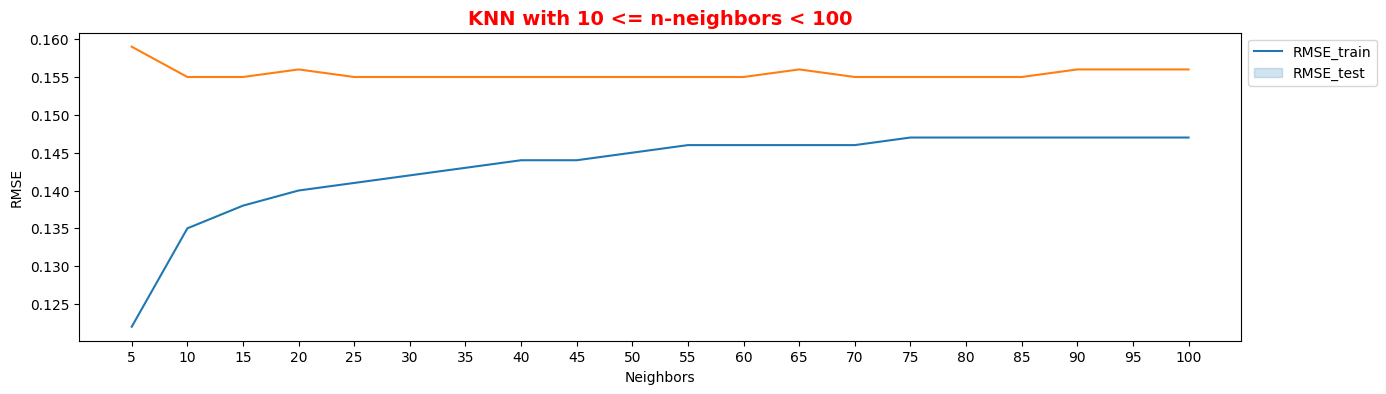

In [35]:
# Plotting the RMSE for training and test sets across different neighbor values in KNN.
fig, ax = plt.subplots(figsize=(15,4))  # Setting the size of the plot
x = np.arange(5, 101, 5)  # Defining x-axis values (neighbor counts)
ax = sns.lineplot(x=x, y=RMSE1_train)  # Plotting RMSE for training set
sns.lineplot(x=x, y=RMSE1_test, ax=ax)  # Plotting RMSE for test set
ax.legend(labels=['RMSE_train', 'RMSE_test'], bbox_to_anchor=(1, 1))  # Adding a legend
ax.set_xlabel('Neighbors')  # Setting X-axis label
ax.set_ylabel('RMSE')  # Setting Y-axis label
ax.set_xticks(np.arange(5, 101, 5))  # Setting X-axis ticks
# Setting the title with custom formatting
ax.set_title('KNN with 10 <= n-neighbors < 100', c='r', fontdict={'c': 'r', 'fontsize': 14, 'weight': 'bold'})
plt.show()  # Displaying the plot

In [36]:
# Calculating the difference between test and train RMSE for each neighbor count and finding the minimum gap.
gap1 = [RMSE1_test[num] - RMSE1_train[num] for num, i in enumerate(RMSE1_train)]
# Identifying the index of the minimum gap
min_gap_index = gap1.index(min(gap1))
# Printing the train and test RMSE values where the gap is minimum
print(f'RMSE Train: {RMSE1_train[min_gap_index]}, RMSE_test: {RMSE1_test[min_gap_index]}')

RMSE Train: 0.147, RMSE_test: 0.155


100-200 NEIGHBOURS

In [37]:
# Evaluating K-Nearest Neighbors Regressor with higher neighbor values, recording RMSEs for both train and test sets.
RMSE_train, RMSE_test = [], []  # Lists to store RMSE for train and test sets

for i in range(100, 201, 5):  # Looping over neighbor values from 100 to 200 in steps of 5
    knn = KNeighborsRegressor(n_neighbors=i)  # Initializing KNN with i neighbors
    knn.fit(X_train, y_train)  # Fitting the model to the training data
    y_train_pred = knn.predict(X_train)  # Predicting on the training data
    knn_train_rmse = np.sqrt(mse(y_train, y_train_pred))  # Calculating RMSE for the train set
    RMSE_train.append(knn_train_rmse.round(3))  # Adding train RMSE to the list
    y_test_pred = knn.predict(X_test)  # Predicting on the test data
    knn_test_rmse = np.sqrt(mse(y_test, y_test_pred))  # Calculating RMSE for the test set
    RMSE_test.append(knn_test_rmse.round(3))  # Adding test RMSE to the list

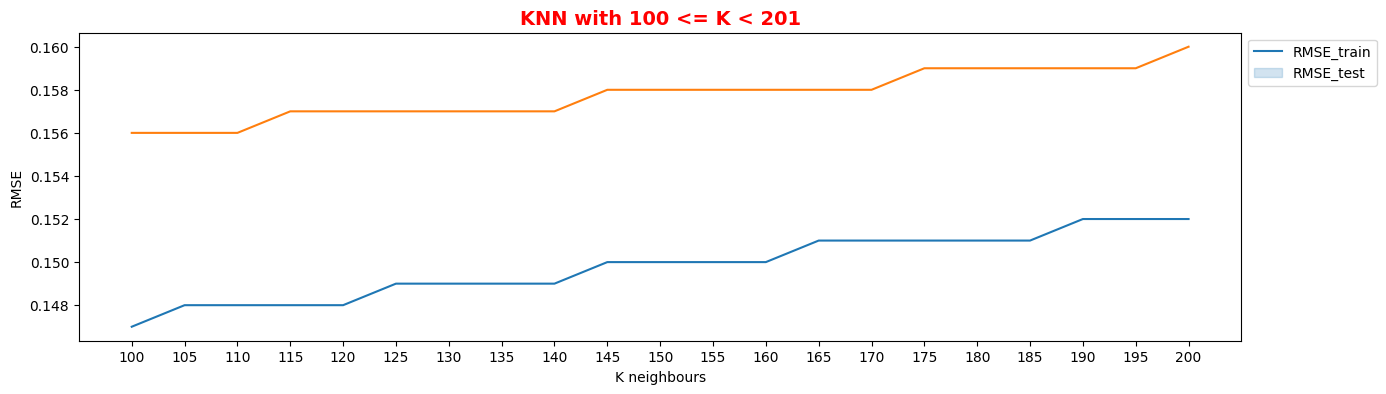

In [38]:
# Plotting RMSE for training and test sets for KNN with neighbor values from 100 to 200.
fig, ax = plt.subplots(figsize=(15,4))  # Setting the size of the plot
x = np.arange(100, 201, 5)  # Defining x-axis values (neighbor counts)
# Plotting RMSE for the training set
ax = sns.lineplot(x=x, y=RMSE_train)
# Plotting RMSE for the test set
sns.lineplot(x=x, y=RMSE_test, ax=ax)
# Adding a legend
ax.legend(labels=['RMSE_train', 'RMSE_test'], bbox_to_anchor=(1, 1))
# Setting X-axis ticks
ax.set_xticks(np.arange(100, 201, 5))
# Setting axis labels and title with custom formatting
ax.set_xlabel('K neighbours')
ax.set_ylabel('RMSE')
ax.set_title('KNN with 100 <= K < 201', c='r', fontdict={'c': 'r', 'fontsize': 14, 'weight': 'bold'})
plt.show()  # Displaying the plot

In [39]:
# Calculating the difference between test and train RMSE for each neighbor count and finding the minimum gap.
gap2 = [RMSE_test[num] - RMSE_train[num] for num, i in enumerate(RMSE_train)]
# Identifying the index of the minimum gap
min_gap_index = gap2.index(min(gap2))
# Printing the train and test RMSE values where the gap is minimum
print(f'RMSE Train: {RMSE_train[min_gap_index]}, RMSE_test: {RMSE_test[min_gap_index]}')


RMSE Train: 0.151, RMSE_test: 0.158


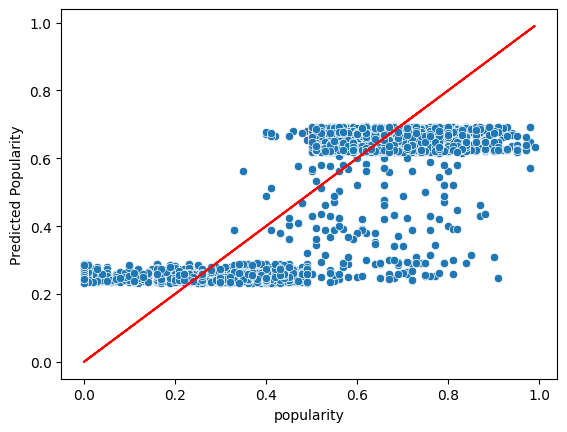

In [40]:
# Creating a scatter plot of actual vs. predicted popularity for the training set.
ax = sns.scatterplot(x=y_train, y=y_train_pred)  # Scatter plot of actual vs. predicted popularity
ax.plot(y_train, y_train, 'r')  # Adding a red diagonal line for reference
ax.set_ylabel('Predicted Popularity')  # Setting the Y-axis label
plt.show()  # Displaying the plot

Decision Tree

In [41]:
# Single run of a Decision Tree Regressor with specific hyperparameters and evaluation.
tree = DecisionTreeRegressor(max_leaf_nodes=41, min_samples_split=2000)  # Initializing Decision Tree Regressor
tree.fit(X_train, y_train)  # Fitting the model to the training data
y_train_pred = tree.predict(X_train).clip(0, 1)  # Predicting on the training data and clipping values between 0 and 1
train_rmse = np.sqrt(mse(y_train, y_train_pred))  # Calculating RMSE for the training set
y_test_pred = tree.predict(X_test).clip(0, 1)  # Predicting on the test data and clipping values between 0 and 1
test_rmse = np.sqrt(mse(y_test, y_test_pred))  # Calculating RMSE for the test set

# Printing the train and test RMSE values
print(f'train: {train_rmse}')
print(f'test: {test_rmse}')

train: 0.14690989425394255
test: 0.15542547329465267


Option 2 loop

In [42]:
# Evaluating Decision Tree Regressor with varying max leaf nodes for a range of values.
RMSE3_train, RMSE3_test = [], []  # Lists to store RMSE for train and test sets

for i in range(2, 200):  # Looping over a range of values for max leaf nodes
    tree = DecisionTreeRegressor(random_state=15, max_leaf_nodes=i)  # Initializing Decision Tree Regressor
    tree.fit(X_train, y_train)  # Fitting the model to the training data
    y_train_pred = tree.predict(X_train).clip(0, 1)  # Predicting on the training data and clipping values between 0 and 1
    train_rmse = np.sqrt(mse(y_train, y_train_pred))  # Calculating RMSE for the train set
    RMSE3_train.append(train_rmse.round(3))  # Adding train RMSE to the list
    y_test_pred = tree.predict(X_test).clip(0, 1)  # Predicting on the test data and clipping values between 0 and 1
    test_rmse = np.sqrt(mse(y_test, y_test_pred))  # Calculating RMSE for the test set
    RMSE3_test.append(test_rmse.round(3))  # Adding test RMSE to the list

In [43]:
# Printing the train and test RMSE values for the Decision Tree Regressor with specific hyperparameters
print(f'train: {train_rmse}')  # Print RMSE for the training set
print(f'test: {test_rmse}')  # Print RMSE for the test set

train: 0.05291011102815689
test: 0.097260125539767


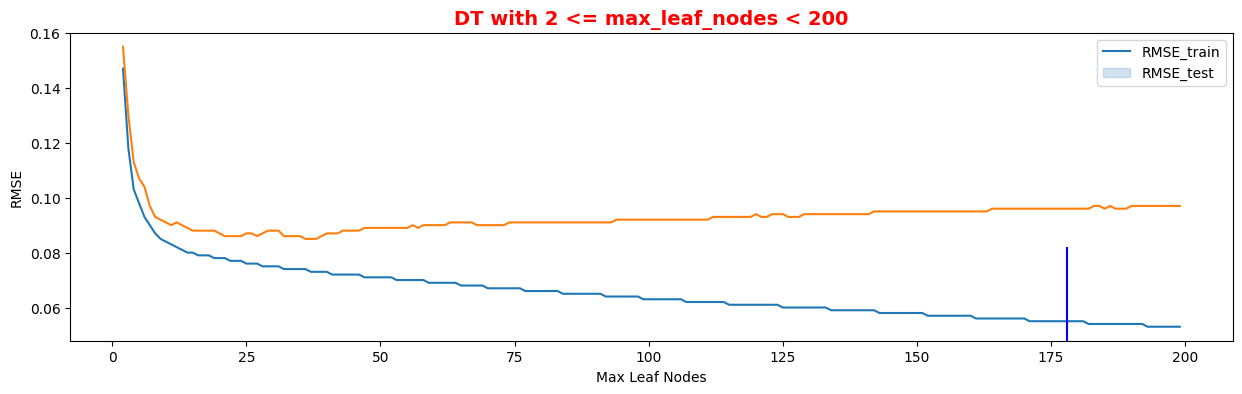

In [44]:
# Plotting RMSE for training and test sets for Decision Trees with varying max leaf nodes.
fig, ax = plt.subplots(figsize=(15, 4))  # Setting the size of the plot
x = np.arange(2, 200)  # Defining x-axis values (max leaf nodes)
# Plotting RMSE for the training set
ax = sns.lineplot(x=x, y=RMSE3_train)
# Plotting RMSE for the test set
sns.lineplot(x=x, y=RMSE3_test, ax=ax)
ax.axvline(x=178, ymin=0, ymax=0.3, color='blue')  # Adding a vertical line at a specific value (178)
ax.legend(labels=['RMSE_train', 'RMSE_test'], bbox_to_anchor=(1, 1))  # Adding a legend
ax.set_xlabel('Max Leaf Nodes')  # Setting the X-axis label
ax.set_ylabel('RMSE')  # Setting the Y-axis label
ax.set_title('DT with 2 <= max_leaf_nodes < 200', c='r', fontdict={'c': 'r', 'fontsize': 14, 'weight': 'bold'})  # Adding a title
plt.show()  # Displaying the plot

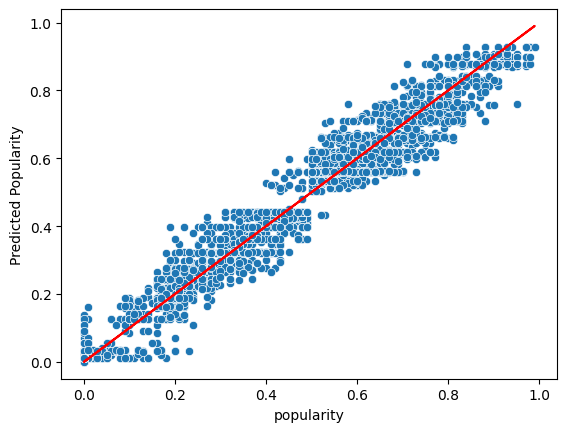

In [45]:
# Creating a scatter plot of actual vs. predicted popularity for the training set.
ax = sns.scatterplot(x=y_train, y=y_train_pred)  # Scatter plot of actual vs. predicted popularity
ax.plot(y_train, y_train, 'r')  # Adding a red diagonal line for reference
ax.set_ylabel('Predicted Popularity')  # Setting the Y-axis label
plt.show()  # Displaying the plot

In [46]:
# Calculating and identifying the minimum and maximum validation gaps in the list gap3
gap3 = [(RMSE3_train[i] / RMSE3_test[i]) for i, num in enumerate(RMSE3_train)]  # Calculate validation gap for each index

# Finding the minimum validation gap and its corresponding index
min_gap = min(gap3)
min_gap_index = gap3.index(min_gap)
print(f'Minimum validation gap is: {min_gap:.3%} in index number {min_gap_index}')

# Finding the maximum validation gap and its corresponding index
max_gap = max(gap3)
max_gap_index = gap3.index(max_gap)
print(f'Maximum validation gap is: {max_gap:.3%} in index number {max_gap_index}')


Minimum validation gap is: 54.639% in index number 191
Maximum validation gap is: 94.839% in index number 0


In [47]:
# Printing feature importances calculated by the Decision Tree Regressor
print('Feature importances:')
for i, col in enumerate(X_train.columns):
    print(f'{col:12}: {tree.feature_importances_[i]:.3f}')

Feature importances:
artists     : 0.001
avg_artist_popularity: 0.262
avg_artist_followers: 0.672
danceability: 0.004
duration_ms : 0.005
energy      : 0.002
loudness    : 0.003
mode        : 0.000
speechiness : 0.006
acousticness: 0.005
liveness    : 0.006
time_signature: 0.000
valence     : 0.006
key_1       : 0.002
key_2       : 0.000
key_3       : 0.000
key_4       : 0.000
key_5       : 0.000
key_6       : 0.000
key_7       : 0.000
key_8       : 0.000
key_9       : 0.000
key_10      : 0.000
key_11      : 0.000
ins_2       : 0.000
ins_3       : 0.001
ins_CA      : 0.000
ins_RU      : 0.000
ins_SW      : 0.000
ins_FR      : 0.005
ins_EN      : 0.000
ins_GR      : 0.000
ins_US      : 0.018


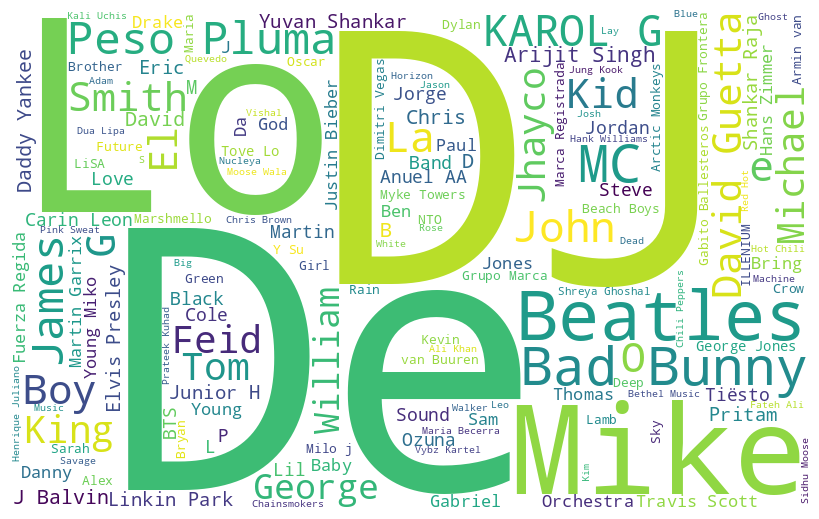

In [48]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate all artist names into a single string
text = ' '.join(df['artists'].dropna().astype(str))

# Create the WordCloud object
wordcloud = WordCloud(width=800, height=500,
                      background_color='white',
                      min_font_size=10).generate(text)

# Plot the WordCloud image
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()